 # <font color="red"> MTH8408 : Méthodes d'optimisation et contrôle optimal </font>

 ## <font color="orange"> Laboratoire 4: Optimisation sans contraintes et méthodes itératives </font>


Travail réalisé par Julien Pallage

Matricule: 2012861

3 mars 2024

In [27]:
using Pkg
Pkg.activate(".") #Accède au fichier Project.toml
Pkg.instantiate()
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/code/MTH8408-Hiv24/lab4_JP`


Status `~/Documents/code/MTH8408-Hiv24/lab4_JP/Project.toml`
  [54578032] ADNLPModels v0.7.0
  [6e4b80f9] BenchmarkTools v1.5.0
  [c91e804a] Gadfly v1.4.0
  [7073ff75] IJulia v1.24.2
  [b6b21f68] Ipopt v1.6.2
  [10dff2fc] JSOSolvers v0.11.1
  [4076af6c] JuMP v1.20.0
  [ba0b0d4f] Krylov v0.9.5
  [40e66cde] LDLFactorizations v0.10.1
  [5c8ed15e] LinearOperators v2.7.0
  [a4795742] NLPModels v0.20.0
  [f4238b75] NLPModelsIpopt v0.10.1
  [792afdf1] NLPModelsJuMP v0.12.5
  [7cde8186] NLSProblems v0.5.1
⌃ [5049e819] OptimizationProblems v0.5.0
  [91a5bcdd] Plots v1.40.1
  [581a75fa] SolverBenchmark v0.6.0
  [ff4d7338] SolverCore v0.3.7
  [37e2e46d] LinearAlgebra
  [56ddb016] Logging
  [de0858da] Printf
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [28]:
using LinearAlgebra, Krylov, NLPModels, Printf, Logging, SolverCore, Test, ADNLPModels

In [29]:
using BenchmarkTools, SolverCore, LinearOperators
using JSOSolvers, NLPModels # 
using SolverBenchmark
using LinearAlgebra, NLPModels, Printf
#using OptimizationProblems.ADNLPProblems
using NLSProblems

### Exercice 0: Introduction aux NLSModels

On a vu dans les lab précédents l'utilisation des NLPModels pour représenter un problème d'optimisation. Dans le cas de l'optimisation de moindre carrées non-linéaires, il existe un type spécifique: **NLSModel**.

$\min_x \frac{1}{2} \| F(x) \|^2$

Comme un NLPModel classique on peut faire appels aux fonctions: obj, grad, hprod ...

Mais on peut aussi utiliser des fonctions relatives à $F$:
https://juliasmoothoptimizers.github.io/NLPModels.jl/stable/#Nonlinear-Least-Squares

L'équivalent des ADNLPModel pour ce cas est la fonction: ADNLSModel.
Lien vers le site: https://juliasmoothoptimizers.github.io/ADNLPModels.jl/stable/

En utilisant les ADNLSModels écrire un modèle dont la fonction résidue est donné par FH ci-dessous.

In [30]:
#Test problem:
FH(x) = [x[2]+x[1].^2-11, x[1]+x[2].^2-7]
x0H = [10., 20.]
###########################
#Utilise FH et x0H pour créer un ADNLSModel
nequ = length(FH(x0H))
himmelblau_nls = ADNLSModel(FH, x0H, nequ)
###########################


#some tests
print(residual(himmelblau_nls, x0H))
print(FH(x0H))

[109.0, 403.0][109.0, 403.0]

### Exercice 1: Gauss-Newton

Dans cet exercice, on complète une implémentation de la méthode Gauss-Newton avec région de confiance (paramétrée par $\Delta$) discutée en cours.

Il faut compléter les morceaux:
- utiliser les fonctions des NLSModels pour obtenir F et sa jacobienne (ici on utilise pas la jacobienne mais juste le produit jacobienne-vecteur).
Parcourez la documentation de NLPModels pour déterminer la fonction adéquat, indice les fonctions pour les NLSModels indiquent des `nls` au lieu de `nlp` dans la documentation.
- Utiliser la fonction `lsmr` du package `Krylov.jl` pour résoudre le système linéaire avec une contrainte de `radius`. Lisez la [documentation de `lsmr`](https://jso.dev/Krylov.jl/stable/solvers/ls/#LSMR).

In [31]:
"""
Function that implements the Gauss-Newton algorithm for Nonlinear Least-square resolution.
"""
function gauss_newton(nlp      :: AbstractNLSModel, 
                      x        :: AbstractVector, 
                      ϵ        :: AbstractFloat = 1e-6;
                      η₁       :: AbstractFloat = 1e-3, 
                      η₂       :: AbstractFloat = 0.66, 
                      σ₁       :: AbstractFloat = 0.25, 
                      σ₂       :: AbstractFloat = 2.0,
                      max_eval :: Int = 1_000, 
                      max_time :: AbstractFloat = 60.,
                      max_iter :: Int = typemax(Int64)
                      )
    ######################################################
    Fx = residual(nlp, x)# le résidu
    Jx =  jac_residual(nlp, x) # operateur qui représente le jacobien du résidu
    ######################################################
    normFx = norm(Fx)

    Δ = 1.

    iter = 0    

    el_time = 0.0
    tired   = neval_residual(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    normdual   = norm(Jx' * Fx)
    optimal    = min(normFx, normdual) ≤ ϵ

    @info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        #################################
        #Compute a direction satisfying the trust-region constraint
        (d, stats)  = lsmr(-Jx,Fx,radius=Δ)
        #################################
      
        too_small = norm(d) < 1e-15
        if too_small #the direction is too small
            status = :too_small
        else
            xp      = x + d
            ###########################
            Fxp     =  residual(nlp, xp)# évalue le résidu en xp
            ###########################
            normFxp = norm(Fxp)

            Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2)
            Ared = 0.5 * (normFx^2 - normFxp^2)

            if Ared/Pred < η₁
                Δ = max(1e-8, Δ * σ₁)
                status = :reduce_Δ
            else #success
                x  = xp
                ###########################
                Jx = jac_residual(nlp, x)# réevalue le jacobien en x
                ###########################
                Fx = Fxp
                normFx = normFxp
                status = :success
                if Ared/Pred > η₂ && norm(d) >= 0.99 * Δ
                    Δ *= σ₂
                end
            end
        end

        @info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), Δ])

        el_time      = time() - start_time
        iter   += 1

        many_evals   = neval_residual(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit
        normdual     = norm(Jx' * Fx)
        optimal      = min(normFx, normdual) ≤ ϵ
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_residual(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp; status, solution = x,
                                 objective = normFx^2 / 2,
                                 dual_feas = normdual,
                                 iter = iter, 
                                 elapsed_time = el_time)
end

gauss_newton

On fait un premier test avec himmelblau.

In [32]:
stats = gauss_newton(himmelblau_nls, himmelblau_nls.meta.x0, 1e-6)
@test stats.status == :first_order

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:34
┌ Info:      0       3   3.8e+02          success   1.0e+00   2.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:75
┌ Info:      1       4   3.1e+02          success   2.0e+00   4.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:75
┌ Info:      2       5   1.9e+02          success   4.0e+00   8.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:75
┌ Info:      3       6   4.5e+01          success   7.7e+00   8.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:75
┌ Info:      4       7   9.5e+00          success   3.4e+00   8.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:75
┌ Info:      5       8   1.6e+00          success   1.3e+00   8.0e+00
└ @ Main /home/j

Test Passed

On essaye notre algorithme sur le problème BNST2 de la librairie NLSProblems avec 400 variables.

In [69]:
nls_model = BNST2(400)
stats = gauss_newton(nls_model, nls_model.meta.x0)
@test stats.status == :first_order

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:34
┌ Info:      0       2   1.0e+00          success   1.0e+00   2.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:75
┌ Info:      1       3   4.2e-16          success   1.0e+00   2.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:75


Test Passed

## Exercice 2: Méthode Levenberg-Marquard inexacte

Dans cet exercice, on complète une implémentation de la méthode Levenberg-Marquardt. Pour compléter le code `lm_param` on va utiliser les fonctions suivantes:
- `dsol` qui calcul la solution du système 
$\min_x \frac{1}{2}\|J(x) d + F(x)\| + \lambda \|x\|^2$
avec la fonction `lsqr` du package `Krylov.jl`.
- `multi_sol` qui pour un entier nl donné et un $\mu$ va résoudre le problème de dsol pour nl valeurs de $\lambda$ (autour de la valeur $\mu$). Par exemple, pour $\mu=10^{-6}$ et $nl=3$, on prendra $\lambda=10^{-7}, 10^{-6},10^{-5}$.
Parmis les `nl` directions calculées, on retourne celle qui donne la plus petite valeur de $\|F(x+d)\|^2$.

In [70]:
function dsol(Fx, Jx, λ, τ)
    (d, stats) = lsqr(-Jx, Fx, λ = λ, atol = τ)
    return (d, stats)
end

dsol (generic function with 1 method)

In [71]:
"""
Function that generate a list of lambdas according to the requirements.
Inputs: mean lambda, number of lambda to generate 
Output: List of lambdas
"""
function generate_lambdas(λ :: Float64, nl :: Int64)
    nl = (mod(nl, 2) == 0) ? nl + 1 : nl + 0     
    lambda_list = []
    push!(lambda_list, λ)
    half = trunc(nl/2)
    for i in range(start = 1, stop = half, step = 1)
        plus_lamb = (λ * 10^(i))
        minus_lamb = (λ * 10^(-i))
        append!(lambda_list, plus_lamb)
        append!(lambda_list, minus_lamb)
    end
    return lambda_list
   
end


"""
Function that generate the best direction according to different regularization parameters.
Inputs: nlp, x, Fx, Jx, lambda, Tau
Output: best direction
"""
function multi_sol(nlp, x, Fx, Jx, λ, τ; nl = 3)
    lambda_list = generate_lambdas(λ, Int(nl))
    count = 0
    best_NormFx = 0
    best_d = 0
    for lambd in lambda_list
        (d, stats)=  dsol(Fx, Jx, lambd, τ)
        nextX = x + d
        nextFx = residual(nlp, nextX)
        next_normFx = (norm(nextFx)).^2
        if count == 0
            best_NormFx = next_normFx
            best_d = d
        elseif (next_normFx < best_NormFx)
            best_NormFx = next_normFx
            best_d = d
        else
            continue 
        end
        
        count += 1
    end
    return best_d
end

multi_sol

In [72]:
"""
Function that implements the Levenberg-Marquard algorithm with LSQR.
"""
function lm_param(nlp      :: AbstractNLSModel, 
                  x        :: AbstractVector, 
                  ϵ        :: AbstractFloat = 1e-6;
                  η₁       :: AbstractFloat = 1e-3, 
                  η₂       :: AbstractFloat = 0.66, 
                  σ₁       :: AbstractFloat = 10.0, 
                  σ₂       :: AbstractFloat = 0.5,
                  max_eval :: Int = 10_000, 
                  max_time :: AbstractFloat = 60.,
                  max_iter :: Int = typemax(Int64)
                  )
    ######################################################
    Fx = residual(nlp, x)# le résidu
    Jx = jac_residual(nlp, x) # operateur qui représente le jacobien du résidu
    ######################################################
    normFx   = norm(Fx)
    normdual = norm(Jx' * Fx)

    iter = 0    
    λ = 0.0
    λ₀ = 1e-6
    η = 0.5
    τ = η * normdual

    el_time = 0.0
    tired   = neval_residual(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    optimal    = min(normFx, normdual) ≤ ϵ

    @info log_header([:iter, :nf, :primal, :status, :nd, :λ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        ###########################
        # (d, stats)  = lsqr(Jx, -Fx, λ = λ, atol = τ)
        #d = multi_sol(nlp, x, Fx, Jx, λ, τ)
        (d, stats) = dsol(Fx, Jx, λ, τ)
        ###########################
        
        too_small = norm(d) < 1e-16
        if too_small #the direction is too small
            status = :too_small
        else
            xp      = x + d
            ###########################
            Fxp     = residual(nlp, xp)# évalue le résidu en xp
            ###########################
            normFxp = norm(Fxp)

            Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2 - λ*norm(d)^2)
            Ared = 0.5 * (normFx^2 - normFxp^2)

            if Ared/Pred < η₁
                λ = max(λ₀, σ₁ * λ)
                status = :increase_λ
            else #success
                x  = xp
                ###########################
                Jx = jac_residual(nlp, x) # réevalue le jacobien en x
                ###########################
                Fx = Fxp
                normFx = normFxp
                status = :success
                if Ared/Pred > η₂
                    λ = max(λ * σ₂, λ₀)
                end
            end
        end

        @info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), λ])

        el_time      = time() - start_time
        iter        += 1
        many_evals   = neval_residual(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit
        normdual     = norm(Jx' * Fx)
        optimal      = min(normFx, normdual) ≤ ϵ

        η = λ == 0.0 ? min(0.5, 1/iter, normdual) : min(0.5, 1/iter)
        τ = η * normdual
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_residual(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp; status, solution = x,objective = normFx^2 / 2, dual_feas = normdual, iter = iter, elapsed_time = el_time)#GenericExecutionStats(status, nlp, solution = x,objective = normFx^2 / 2,dual_feas = normdual,iter = iter, elapsed_time = el_time)
end

lm_param

We begin by testing our method on the himmelblau problem.

In [73]:
stats = lm_param(himmelblau_nls, himmelblau_nls.meta.x0, 1e-6)
@test stats.status == :first_order

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:36
┌ Info:      0      48   1.2e+02          success   1.0e+01   1.0e-06
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:78
┌ Info:      1      49   2.9e+01          success   6.0e+00   1.0e-06
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:78
┌ Info:      2      50   5.3e+00          success   2.6e+00   1.0e-06
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:78
┌ Info:      3      51   1.4e+00          success   7.4e-01   1.0e-06
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:78
┌ Info:      4      52   1.7e-01          success   3.4e-01   1.0e-06
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:78
┌ Info:      5      53   5.2e-02          success   2.5e-02   1.0e-06
└ @ Main /home/j

Test Passed

We then test the model on the BNST2 problem from NLSProblems.jl with 400 dimensions.

In [38]:
nls_model = BNST2(400)
stats = lm_param(nls_model, nls_model.meta.x0)
@test stats.status == :first_order

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:36
┌ Info:      0       5   5.6e-16          success   2.0e+00   1.0e-06
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab4_JP/Lab4-notebook.ipynb:77


Test Passed

### Exercice 3 - Benchmark

On benchmark nos algorithmes sur les problèmes de la librairie NLSProblems.

Voir : https://jso.dev/NLSProblems.jl/stable/benchmark/

In [39]:
problems = (eval(problem)() for problem ∈ filter(x -> x != :NLSProblems, names(NLSProblems)))

Base.Generator{Vector{Symbol}, var"#37#39"}(var"#37#39"(), [:BNST2, :BNST3, :LVcon501, :LVcon502, :LVcon503, :LVcon504, :LVcon511, :LVcon512, :LVcon513, :LVcon514  …  :tp354, :tp355, :tp358, :tp370, :tp371, :tp372, :tp373, :tp379, :tp394, :tp395])

In [40]:

solvers = Dict(
  :lm => model -> lm_param(model, model.meta.x0),
  :gn => model -> gauss_newton(model, model.meta.x0),
)

stats = bmark_solvers(
  solvers, problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 100 || get_nvar(prob) < 5),
)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:            NZF1      13       0      first_order   9.1e-05   6.9e-24   1.5e-11   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0      first_order   1.1e-03   2.7e-05   1.2e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh18       6       0         max_eval   4.3e-02   5.0e-03   1.1e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           mgh19      11       0         max_eval   3.0e-01   4.4e-02   3.3e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh20       6       0      first_order   1.2e-03   1.1e-03   3.5e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh21      20       0      first_order   3.2e-04   2.6e-20   5.1e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh22      20       0      first_order   1.4e-04   1.0e-09   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh25      10       0      first_order   5.2e-05   8.0e-16   7.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh26      10       0      first

┌ Info:           tp273       6       0      first_order   7.6e-05   1.3e-15   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp282      10       0      first_order   2.0e-03   2.5e-17   4.0e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp286      20       0      first_order   3.7e-04   2.6e-20   5.1e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp288      20       0         max_eval   2.8e-02   8.8e-06   3.6e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp291      10       0      first_order   1.6e-04   5.6e-10   5.0e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp292      30       0         ma

┌ Info:           tp299     100       0      first_order   1.3e-02   1.8e-16   3.3e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp303      20       0      first_order   6.0e-05   4.0e-14   7.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp304      50       0      first_order   1.9e-04   1.5e-22   1.8e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp305     100       0      first_order   3.6e-04   1.5e-21   1.6e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp370       6       0      first_order   1.4e-03   1.1e-03   3.5e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           tp371       9       0         ma

┌ Info:           tp379      11       0      first_order   4.1e-03   2.0e-02   7.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127


┌ Info:            NZF1      13       0      first_order   4.1e-05   9.2e-19   5.2e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0      first_order   2.0e-04   2.7e-05   1.0e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh18       6       0      first_order   1.2e-04   2.8e-03   3.9e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh19      11       0      first_order   9.0e-04   2.0e-02   3.9e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh20       6       0      first_order   1.7e-04   1.1e-03   8.2e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh21      20       0      first

Dict{Symbol, DataFrames.DataFrame} with 2 entries:
  :lm => 40×39 DataFrame…
  :gn => 40×39 DataFrame…

In [41]:
cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_residual, :neval_jac_residual, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_residual => "# f",
  :neval_jac_residual => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)

for solver ∈ keys(solvers)
  pretty_stats(stats[solver][!, cols], hdr_override=header)
end

┌────────┬───────┬────────┬───────────┬───────────┬────────┬────────┬────────┬────────┬───────────┬─────────────┐
│     id │  name │      n │      f(x) │   ‖∇f(x)‖ │    # f │   # ∇f │  # ∇²f │   iter │         t │      status │
├────────┼───────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼─────────────┤
│     15 │  NZF1 │     13 │  6.93e-24 │  1.45e-11 │     41 │     11 │      0 │     10 │  9.11e-05 │ first_order │
│     67 │ mgh17 │      5 │  2.73e-05 │  1.17e-08 │    149 │     30 │      0 │     37 │  1.08e-03 │ first_order │
│     68 │ mgh18 │      6 │  5.03e-03 │  1.12e-03 │  10001 │   1917 │      0 │   2500 │  4.29e-02 │    max_eval │
│     69 │ mgh19 │     11 │  4.38e-02 │  3.30e-06 │  10001 │   1918 │      0 │   2500 │  2.97e-01 │    max_eval │
│     70 │ mgh20 │      6 │  1.14e-03 │  3.50e-07 │     61 │     16 │      0 │     15 │  1.16e-03 │ first_order │
│     71 │ mgh21 │     20 │  2.61e-20 │  5.11e-09 │    169 │     33 │      0 │     42 │ 

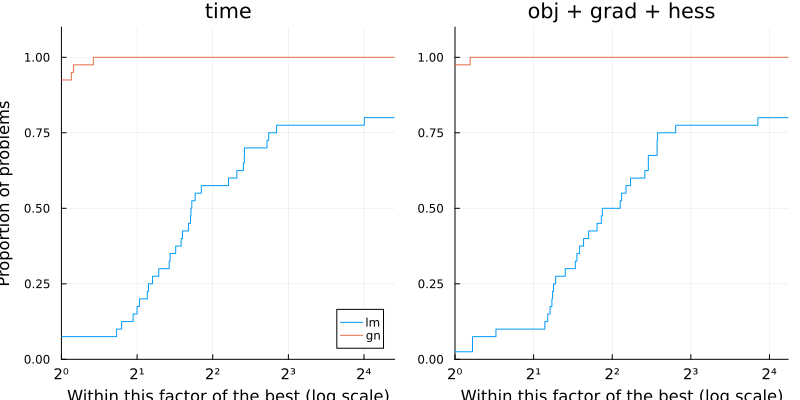

In [42]:
first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["time", "obj + grad + hess"]
costs = [
  df -> .!solved(df) .* Inf .+ df.elapsed_time,
  df -> .!solved(df) .* Inf .+ df.neval_residual .+ df.neval_jac_residual,
]

using Plots
gr()

profile_solvers(stats, costs, costnames)

Pour faire ce benchmark, nous avons utilisé 40 problèmes. Nous avons fait un profil de performance en fonction du temps d'exécution et du nombre d'évaluation du résidual + le nombre d'évaluation du Jacobien. On remarque que l'algorithme de gauss-newton résous l'ensembles des problèmes alors que l'algorithme de Levenberg-Marquard ne réussis pas à résoudre 8 problèmes parmi les 40. On peut déterminer ce chiffre en regardant le nombre de problèmes ayant le status max_eval. On observe une performance nettement supérieur pour la méthode de Gauss-Newton. 

### Exercice 4: Rocket Control

Dans les cellules ci-dessous nous introduisons un modèle de contrôle optimal (cf. https://en.wikipedia.org/wiki/Optimal_control ) pour le contrôle d'une fusée dont une version discrétisée a été modélisé avec JuMP:

Le lien vers le tutoriel:
https://nbviewer.jupyter.org/github/jump-dev/JuMPTutorials.jl/blob/master/notebook/modelling/rocket_control.ipynb

In [43]:
using JuMP, Ipopt

# Create JuMP model, using Ipopt as the solver
rocket = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

c     = 0.5 * sqrt(g_0 * h_0)  # Thrust-to-fuel mass
m_f   = m_c * m_0            # Final mass
D_c   = 0.5 * v_c * m_0 / g_0    # Drag scaling
T_max = T_c * g_0 * m_0        # Maximum thrust

n = 800   # Time steps

@variables(rocket, begin
    Δt ≥ 0, (start = 1/n) # Time step
    # State variables
    v[1:n] ≥ 0            # Velocity
    h[1:n] ≥ h_0          # Height
    m_f ≤ m[1:n] ≤ m_0    # Mass
    # Control
    0 ≤ T[1:n] ≤ T_max    # Thrust
end)

# Objective: maximize altitude at end of time of flight
@objective(rocket, Max, h[n])

# Initial conditions
@constraints(rocket, begin
    v[1] == v_0
    h[1] == h_0
    m[1] == m_0
    m[n] == m_f
end)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@NLexpression(rocket, drag[j = 1:n], D_c * (v[j]^2) * exp(-h_c * (h[j] - h_0) / h_0))
# Grav(h)   = go * (h0 / h)^2
@NLexpression(rocket, grav[j = 1:n], g_0 * (h_0 / h[j])^2)
# Time of flight
@NLexpression(rocket, t_f, Δt * n)

# Dynamics
for j in 2:n
    # h' = v
    
    # Rectangular integration
    # @NLconstraint(rocket, h[j] == h[j - 1] + Δt * v[j - 1])
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        h[j] == h[j - 1] + 0.5 * Δt * (v[j] + v[j - 1]))

    # v' = (T-D(h,v))/m - g(h)
    
    # Rectangular integration
    # @NLconstraint(rocket, v[j] == v[j - 1] + Δt *(
    #                 (T[j - 1] - drag[j - 1]) / m[j - 1] - grav[j - 1]))
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        v[j] == v[j-1] + 0.5 * Δt * (
            (T[j] - drag[j] - m[j] * grav[j]) / m[j] +
            (T[j - 1] - drag[j - 1] - m[j - 1] * grav[j - 1]) / m[j - 1]))

    # m' = -T/c

    # Rectangular integration
    # @NLconstraint(rocket, m[j] == m[j - 1] - Δt * T[j - 1] / c)
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        m[j] == m[j - 1] - 0.5 * Δt * (T[j] + T[j-1]) / c)
end

In [56]:
# Solve for the control and state
println("Solving...")
status = optimize!(rocket)

# Display results
# println("Solver status: ", status)
println("Max height: ", objective_value(rocket))

Solving...


Max height: 1.0128340648308058


In [45]:
value.(h)[n]

1.0128340648308058

In [46]:
# Can visualize the state and control variables
using Gadfly

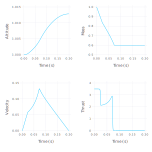

In [57]:
h_jump = value.(h)[:]
m_jump = value.(m)[:]
v_jump = value.(v)[:]
T_jump = value.(T)[:]
delta_jump = value.(Δt)




h_plot = Gadfly.plot(x = (1:n) * value.(Δt), y = h_jump, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = Gadfly.plot(x = (1:n) * value.(Δt), y = m_jump, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = Gadfly.plot(x = (1:n) * value.(Δt), y = v_jump, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = Gadfly.plot(x = (1:n) * value.(Δt), y = T_jump, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))



#### Questions:     
    - i) Transformer le modèle JuMP utilisé ci-dessus en un NLPModel en utilisant le package `NLPModelsJuMP`.    
    - ii) Résoudre ce nouveau modèle avec `Ipopt` en utilisant `NLPModelsIpopt`.    
    - iii) Calcul séparément la différence entre les h,v,m,T, Δt calculés.    
    - iv) Est-ce que le contrôle T atteint ses bornes ?    
    - v) Reproduire les graphiques ci-dessous avec la solution calculée via `NLPModelsIpopt`.


In [58]:
using NLPModels, LinearAlgebra, NLPModelsJuMP, NLPModelsIpopt

Ici, nous transformons le problème Jump en problème NLPModel et le résolvons avec ipopt.

In [59]:
nlp = MathOptNLPModel(rocket)
stats = ipopt(nlp)
print(stats)

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    15185
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45543

Total number of variables............................:     3201
                     variables with only lower bounds:     1601
                variables with lower and upper bounds:     1600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2401
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.96e-01 2.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [60]:
test = stats.solution
print(length(test))


3201

Nous extractons les variables optimales à partir des statistiques de résolution.

In [61]:
delta = stats.solution[1]
v = stats.solution[2:801]
h =  stats.solution[802:1601]
m = stats.solution[1602:2401]
T = stats.solution[2402:3201]

println(length(T))

800


Nous reproduisons les graphiques comme demandé.

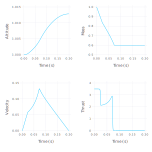

In [62]:
h_plot = Gadfly.plot(x = (1:n) * delta, y = h, Geom.line, Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = Gadfly.plot(x = (1:n) * delta, y = m, Geom.line,Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = Gadfly.plot(x = (1:n) * delta, y = v, Geom.line, Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = Gadfly.plot(x = (1:n) * delta, y = T, Geom.line, Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))

Ici, on observe la différence entre les deux méthodes de résolution, on remarque qu'il n'y a vraiment aucune différence entre les deux.

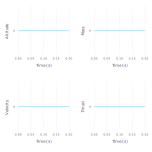

In [63]:
# Differences
h_plot = Gadfly.plot(x = (1:n) * delta, y = h - h_jump, Geom.line, Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = Gadfly.plot(x = (1:n) * delta, y = m - m_jump, Geom.line,Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = Gadfly.plot(x = (1:n) * delta, y = v - v_jump, Geom.line, Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = Gadfly.plot(x = (1:n) * delta, y = T - T_jump, Geom.line, Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))

La norme des différences donne exactement la même réponse.

In [64]:
println(norm(h - h_jump))
println(norm(v - v_jump))
println(norm(m - m_jump))
println(norm(T - T_jump))
println(norm(delta - delta_jump))

0.0
0.0
0.0
0.0
0.0


Finalement, on remarque que T atteint sa valeur maximale de 3.5 en début d'ascension puis sa valeur minimale, zéro, vers 0.07 secondes.